# Linear Recidivism Model

We say the recidivism is linear by saying,

- Apply the harzard model and the mix-in effect applies to $a_j, b_j$ on a basis of community
- up to now we do not assume disparity amongst groups
- we assume that there is one group
- assume the decision is a random static threshold policy

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from simulator import *
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
j = 0
d = 2
n = 5
T = 100
p = generate_gamma_p(n)
x = np.random.randint(0, 60, n)
x = x/x.sum()
actions = [
    RandomizedDecision(d, theta=np.array([0.1, 0.1]), func="random")
    for _ in range(T)
]
state = RecidState(0, x=x, p=p)

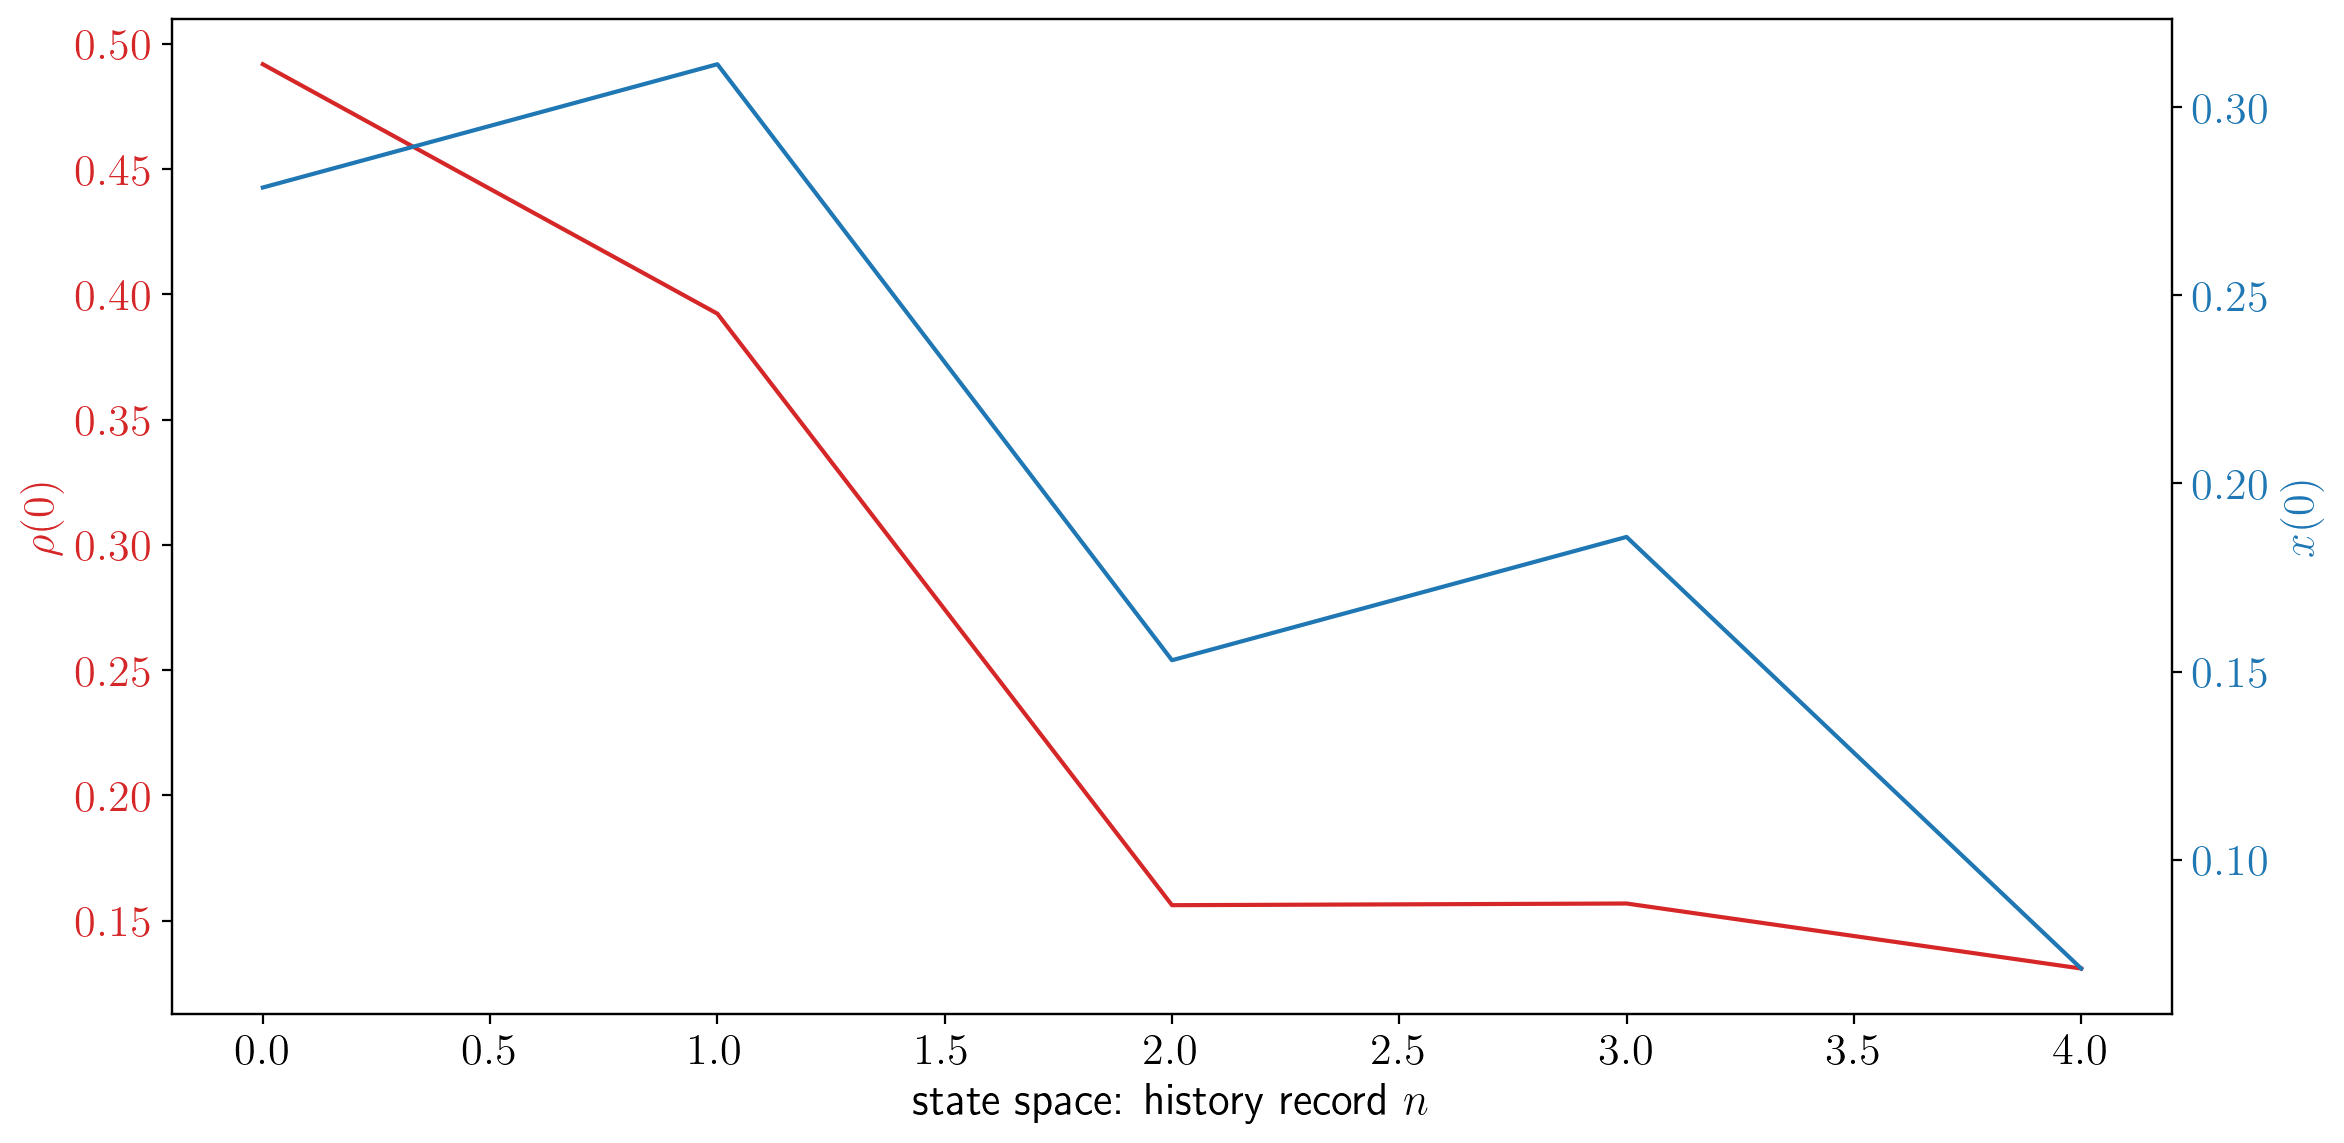

<Figure size 2400x1200 with 0 Axes>

In [4]:
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('state space: history record $n$')
ax1.set_ylabel('$\\rho(0)$', color=color)
ax1.plot(range(n), p.p, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$x(0)$', color=color)  # we already handled the x-label with ax1
ax2.plot(range(n), x, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig("./p1.png", dpi=1000)

# Stationarity of Long-Run Recidivates with Uniform treatment $\tau_j \equiv \tau$

## Vector Plots for Equilibrium
- use random classification

- we change different records

In [5]:
np.random.seed(1)
j = 0
d = 2
n = 15
nullscope = 20
T = 350
K = 10
rate_state_decay=1.0
rate_state_decay_last = 0.6
rate_exogenous_arrival = 0.1 
zeta = np.sort(np.random.rand(n)) * 2
ee = np.ones(n)
mixincost = {
    "ones": ee,
    "positive": zeta, 
    "negative": -zeta/3, 
    "both": zeta - zeta.min()*3
}
mixincost["negative"][:] = -0.1


In [6]:
def plot_equilibrium(
    name, zt, 
    fractions=[(.8,.8), (.8,.05)],
    xscale=1
):
    data_xy = []
    data_uv = []
    data_theta = [theta * 0.1 for theta in range(1, 10)]
    data_leaving = []

    for theta in data_theta:
        xy = []
        uv = []
        actions = [
            RandomizedDecision(d, theta=np.array([theta, 0]), func="random")
            for _ in range(T)
        ]
        series = []
        for k in range(K):
            p = generate_gamma_p(n)
            x = np.random.randint(0, 10, n)
            x = x/x.sum()*xscale

            state = RecidState(0, x=x, p=p)
            traj = run(
                T,
                state,
                actions=actions,
                options_mix=2,
                zeta=zt,
                rate_exogenous_arrival=rate_exogenous_arrival * xscale,
                rate_state_decay=rate_state_decay,
                rate_state_decay_last=rate_state_decay_last,
                func_cost_function=DecisionCost.func_linear_cost,
                verbose=False
            )
            s = traj[0]
            # null
            for i in range(nullscope):
                _xy_at_t = np.array([s.s, s.total_x - s.s]) * i / nullscope # / s.total_x 
                _xy_at_prev = np.zeros(2) if i == 0 else xy[-1]
                grad = _xy_at_t - _xy_at_prev
                grad = grad

                uv.append(grad)
                xy.append(_xy_at_t)

            for idx, s in enumerate(traj):
                # _xy_at_t = np.log2(s.a.recid_treat.sum(1))
                # _xy_at_t = np.array([s.s, s.total_x - s.s]) 
                _xy_at_t = np.array([s.s, s.total_x - s.s]) # / s.total_x
                # _xy_at_t = np.array([s.s, s.active_x - s.s])
                # _xy_at_t[0] = _xy_at_t[0] 
                _xy_at_prev = np.zeros(2) if (nullscope+idx) == 0 else xy[-1]
                grad = _xy_at_t - _xy_at_prev
                grad = grad

                uv.append(grad)
                xy.append(_xy_at_t)
            series.append(traj)

        xy = np.vstack(xy)[0:,:]
        uv = np.vstack(uv)[0:,:]
        # Q = ax.quiver(
        #     xy[:,0], xy[:,1], uv[:,0], uv[:,1], 
        #     units='width', 
        #     pivot='tip',
        #     scale_units="xy",
        #     scale=1 / 0.9,
        #     width=1e-3,
        # )
        # for idx in range(0, K, K//5):
        data_xy.append(xy)
        data_uv.append(uv)
        data_leaving.append(sum(tr.x[-1]*(tr.p.p[-1]) for tr in traj))

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    ax.set_xlabel("recidivists at $t$")
    ax.set_ylabel("non-recidivists at $t$")
    # ax.set_xscale('log')
    # ax.set_yscale('log')

    controls = []
    for idt, (xy, uv, theta) in enumerate(zip(data_xy, data_uv, data_theta)):
        for idx in range(0, K):
            _xy = xy[idx*(nullscope+T)+nullscope:(idx+1)*(T+nullscope),:]
            _uv = uv[idx*(nullscope+T)+nullscope:(idx+1)*(T+nullscope),:]
            kwargs = {}
            if idt == 0:
                kwargs = {"color": "blue"}
            Q = ax.quiver(
                _xy[:,0], _xy[:,1], 
                _uv[:,0], _uv[:,1], 
                units='width', 
                # units='dots', 
                pivot='tip',
                scale_units="xy",
                scale=1 / 0.9,
                width=1e-3,
                **kwargs
            )
            # L = ax.plot(
            #     _xy[:,0], _xy[:,1], 
            #     linestyle="-.",
            #     # label=idx,
            #     linewidth=0.8
            # )
            # break

        controls.append([_xy[-1,0], _xy[-1,1]])
        if idt == 0:
            pv = ax.annotate(
                # "$\\textrm{EQLB at}~\\tau:$" 
                "$"+f"({_xy[-1,0]:.2f}, {_xy[-1,1]:.2f})"+"$\n"
                + "$~\\tau:$" + f"$~{theta:.2f}$\n"
                + "$\\textrm{left}$:~" 
                + f"${data_leaving[idt]:.2f}$", 
                fractions[0], 
                # verticalalignment="top",
                # horizontalalignment="left",
                xycoords='axes fraction'
            )
#             pv2 = ax.text(
#                 _xy[-1,0] + 0.02, _xy[-1,1] - 0.,    
#                 verticalalignment="top",
#                 horizontalalignment="left",
#             )
        if idt == len(data_theta)-1:
            pv = ax.annotate(
                # "$\\textrm{EQLB at}$
                "$"+f"({_xy[-1,0]:.2f}, {_xy[-1,1]:.2f})"+"$\n"
                + "$~\\tau:$" + f"$~{theta:.2f}$\n"
                + "$\\textrm{left}$:~" 
                + f"${data_leaving[idt]:.2f}$", 
                fractions[1],
                xycoords='axes fraction'
                # verticalalignment="top",
                # horizontalalignment="right",
            )
#             pv2 = ax.text(
#                 _xy[-1,0] - 0.03, _xy[-1,1] - 0.6, 
#                 "$\\textrm{left}$:~" + f"${data_leaving[idt]:.2f}$", 
#                 verticalalignment="top",
#                 horizontalalignment="right",
#             )



    controls = np.array(controls)
    ax.plot(controls[:,0], controls[:,1], linestyle="--")

    # draw a single class curve
    # xmax = xy[:,0].max() / actions[0].theta[0]
    # xx = np.arange(0, xmax, 0.1)
    # rec = actions[0].theta[0] * xx
    # nonrec = xx - rec
    # Ltheta = ax.plot(
    #     rec, nonrec, linestyle="dotted", linewidth=1.2,
    #     label="decision $\\theta$"
    # )
    # ax.legend()
    plt.show()

    # 
    fig.savefig(f"./{name}-equilibrium.png")

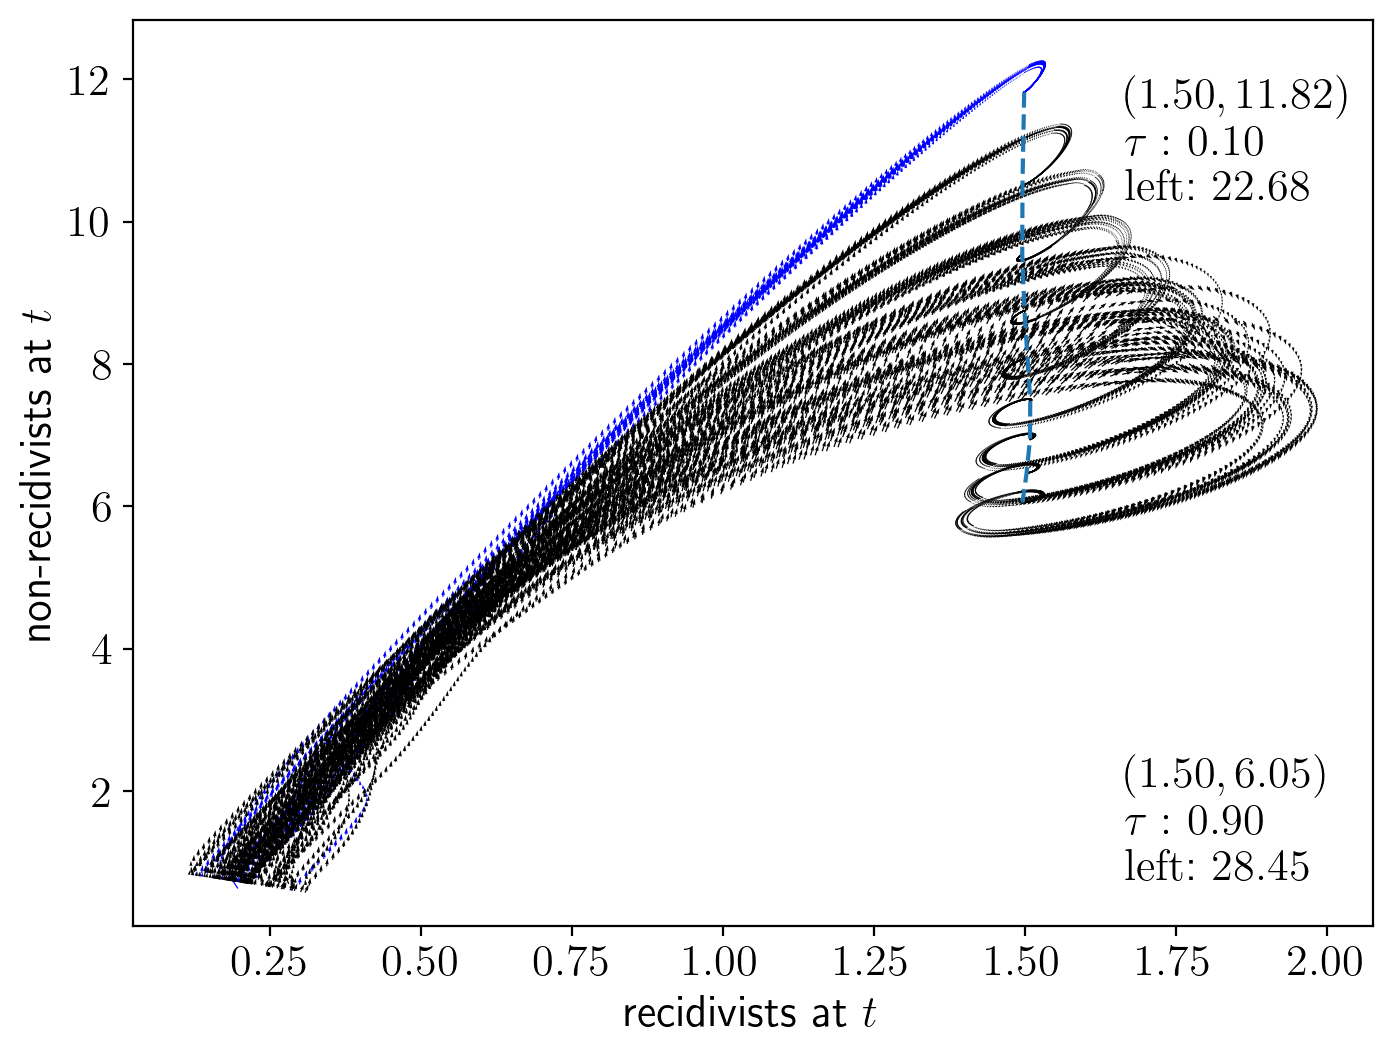

In [7]:
plot_equilibrium('positive', mixincost['ones'])

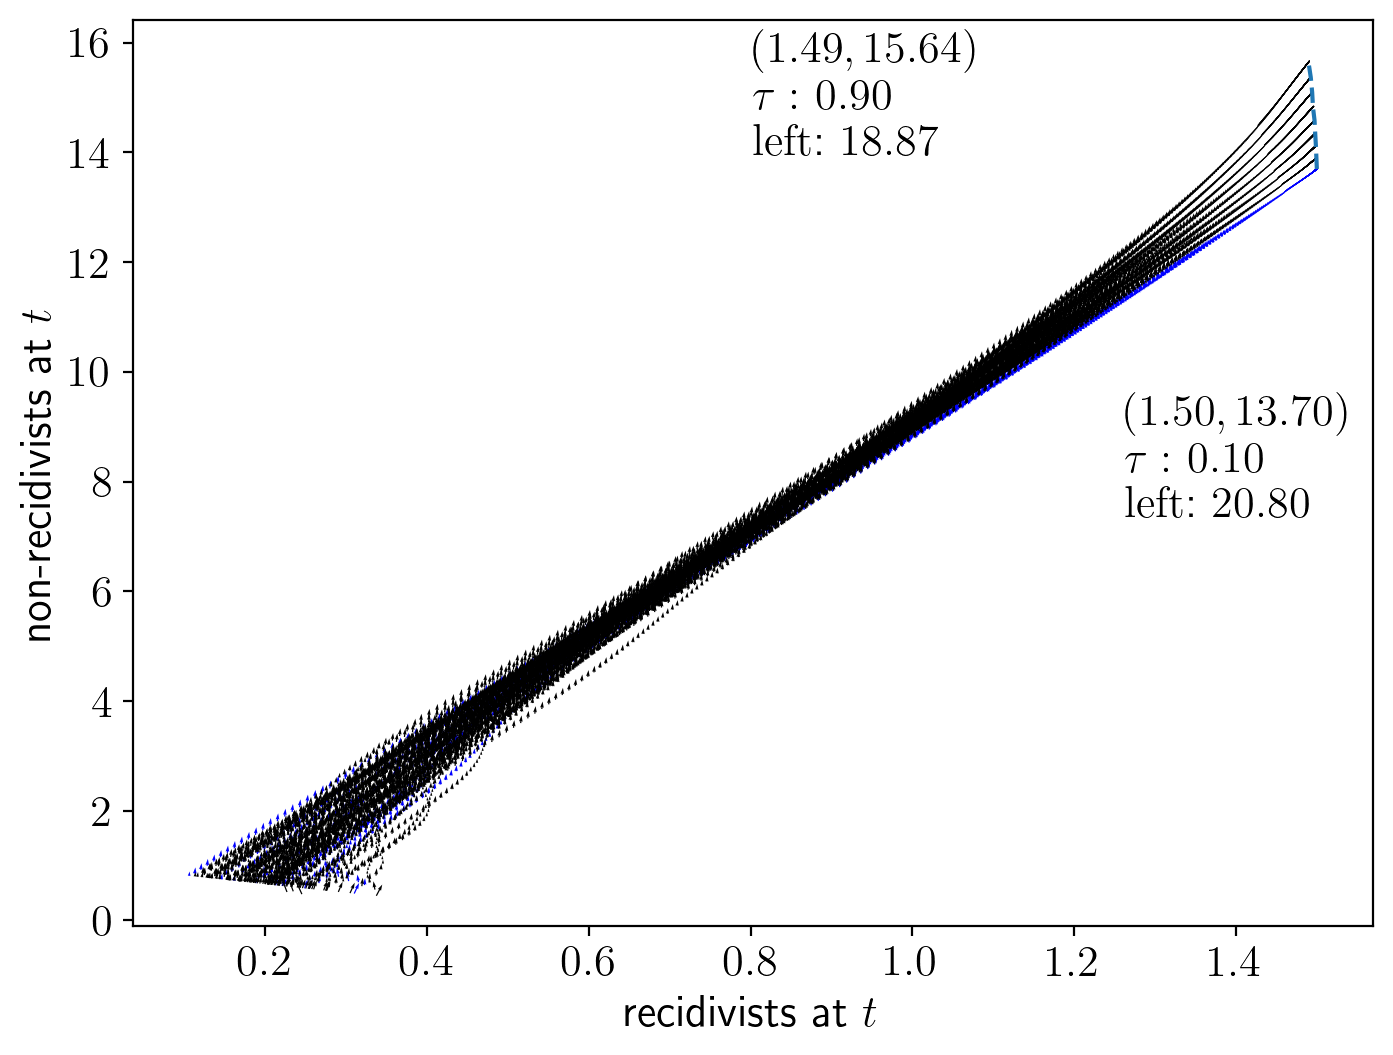

In [8]:
plot_equilibrium('negative', mixincost['negative'], [(.8,.45), (.5,.85)])

## Equilibrium analysis

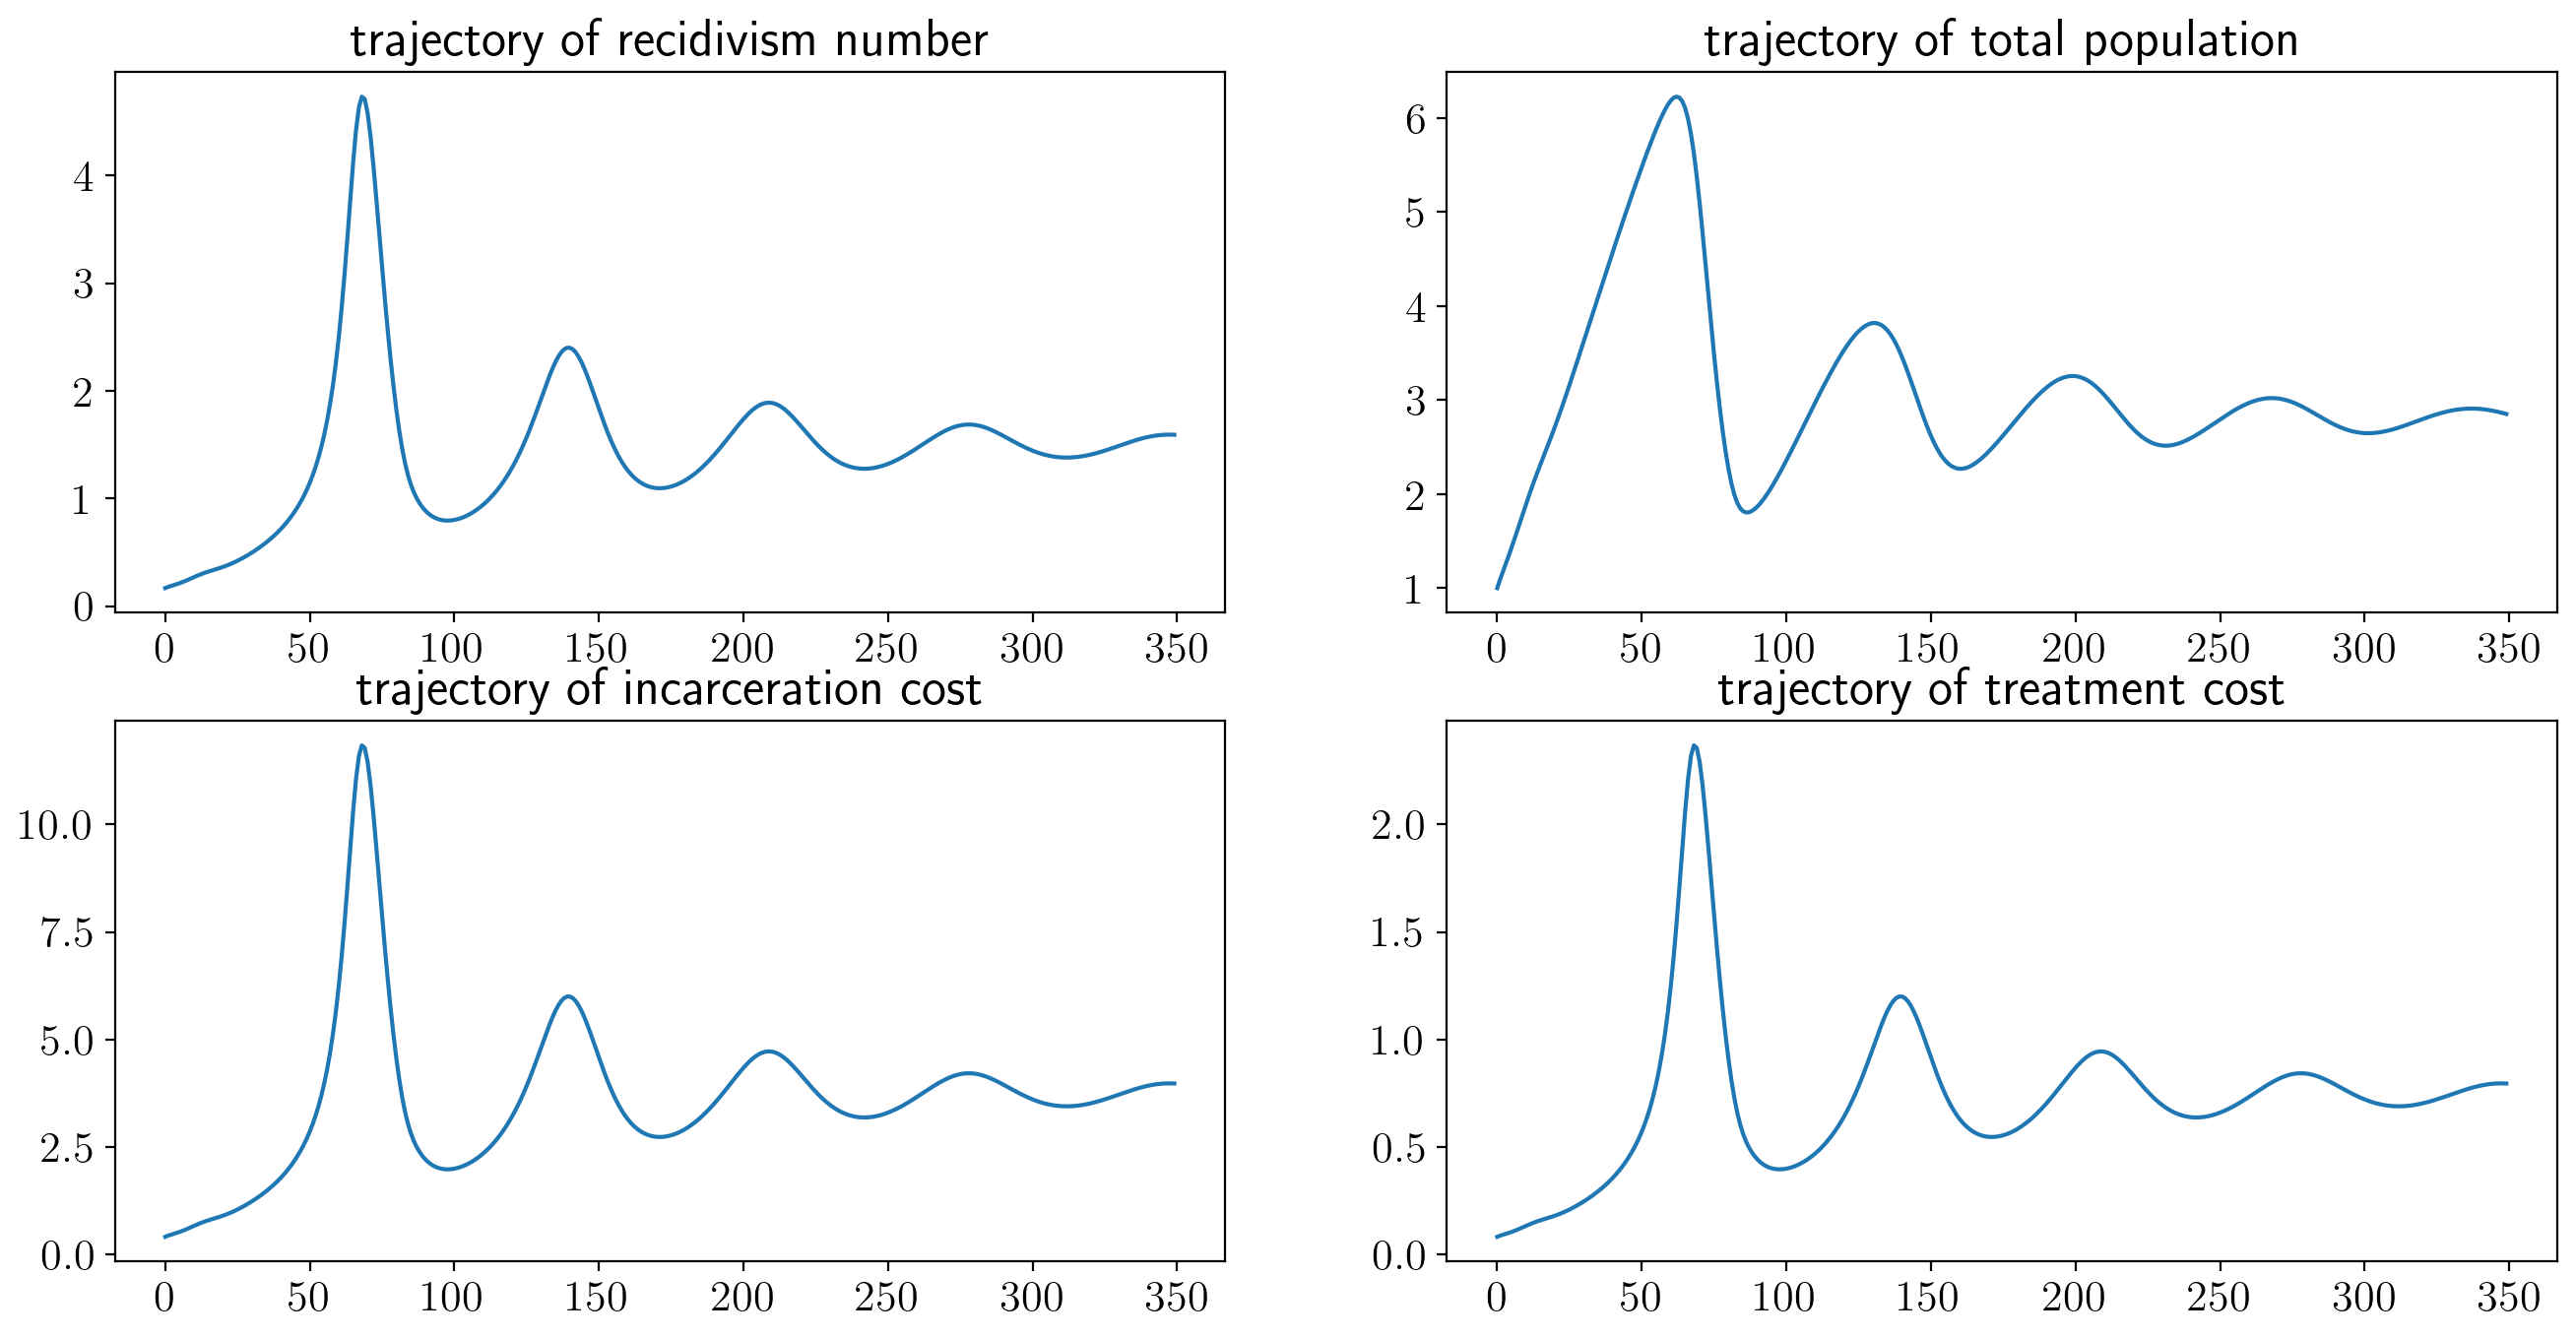

In [31]:
xscale=1
p = generate_gamma_p(n)
x = np.random.randint(0, 10, n)
x = x/x.sum()*xscale
state = RecidState(0, x=x, p=p)
actions = [
    RandomizedDecision(d, theta=np.array([0.5, 0]), func="random")
    for _ in range(T*2)
]
rate_exogenous_arrival = 0.1*state.x.sum()
rate_state_decay=1.0
traj = run(
    T,
    state,
    actions=actions,
    options_mix=1,
    # options_mix=2, 
    zeta=zeta,
    rate_exogenous_arrival=rate_exogenous_arrival,
    rate_state_decay=rate_state_decay,
    func_cost_function=DecisionCost.func_linear_cost,
    verbose=False
)
show_traj(traj)

In [10]:
se = traj[-1]

### Compute $(I- \Phi^T)^{-1}$

In [11]:
a = se.phi_data[:n]
b = se.phi_data[n:]
ee = np.ones(n)

In [12]:
c = b/a[:-1]

In [13]:
se.x * se.p.p

array([0.10090791, 0.10197416, 0.10302914, 0.10401926, 0.10492402,
       0.10573436, 0.10644566, 0.10705522, 0.10756134, 0.10796296,
       0.10825958, 0.10845127, 0.10853875, 0.10852343, 0.10840743])

In [14]:
(1 - se.p.p*(se.Phi.T@ee) - se.p.p * se.p.Q)/(1-se.p.p)/(se.Phi.T@ee + se.p.Q)

array([1.16672556, 1.16565747, 1.16444262, 1.16325787, 1.16212296,
       1.16102965, 1.15996675, 1.15892537, 1.15789953, 1.15688596,
       1.15588346, 1.15489256, 1.15391501, 1.15295356, 1.15201159])

In [15]:
np.exp(0.5*zeta.T@(se.x*se.p.p)/n*0.2), np.exp(0.5*se.lbda[0]*zeta.T@(ee)/n*0.2)

(1.0077253759659897, 1.0071731572166234)

In [16]:
se.p.p

array([0.21564805, 0.31725732, 0.40621478, 0.48392156, 0.5516797 ,
       0.61067416, 0.6619733 , 0.70653418, 0.74520952, 0.77875532,
       0.80783887, 0.83304681, 0.85489303, 0.87382635, 0.89023767])

In [17]:
se.recid_treat

array([[0.05045396, 0.05098708, 0.05151457, 0.05200963, 0.05246201,
        0.05286718, 0.05322283, 0.05352761, 0.05378067, 0.05398148,
        0.05412979, 0.05422564, 0.05426938, 0.05426171, 0.05420371],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [18]:
np.diag(se.p.p) @ se.Phi.toarray().T

array([[0.16914397, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06841592, 0.21660511, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.12887461, 0.24120433, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.19657609, 0.24974148, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2669697 , 0.24732921,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

In [19]:
se.a.recid_no_treat

array([[0.10782402, 0.15862866, 0.20310739, 0.24196078, 0.27583985,
        0.30533708, 0.33098665, 0.35326709, 0.37260476, 0.38937766,
        0.40391944, 0.4165234 , 0.42744652, 0.43691318, 0.44511884],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [20]:
se.recid_no_treat + se.recid_treat

array([[0.10090791, 0.10197416, 0.10302914, 0.10401926, 0.10492402,
        0.10573436, 0.10644566, 0.10705522, 0.10756134, 0.10796296,
        0.10825958, 0.10845127, 0.10853875, 0.10852343, 0.10840743],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [21]:
p0 = se.p.p[0]
q0 = se.p.Q[0]
beta = np.exp(0.5*zeta.T@(se.x*se.p.p)/n*0.2)

In [22]:
(1-p0*((1-p0) + q0))/(1-p0)/((1-p0) + q0)

1.1667255568313828

In [23]:
p0*p0*(beta-1) + p0*(1+q0 - q0*beta - 2*beta) + q0*beta + beta - 1

-0.11028939158586404

In [24]:
(beta-1), (1+q0 - q0*beta - 2*beta), q0*beta + beta - 1

(0.007725375965989656, -1.016223289528578, 0.10849791356258853)

## Monotonicity of $\rho$

In [25]:
xscale=1
p = generate_gamma_p(n)
x = np.random.randint(0, 10, n)
x = x/x.sum()*xscale
state = RecidState(0, x=x, p=p)
actions = [
    RandomizedDecision(d, theta=np.array([0.5, 0]), func="random")
    for _ in range(T)
]
rate_exogenous_arrival = 0.1*state.x.sum()
rate_state_decay=1.0
traj = run(
    T,
    state,
    actions=actions,
    options_mix=1,
    # options_mix=2, 
    zeta=zeta,
    rate_exogenous_arrival=rate_exogenous_arrival,
    rate_state_decay=rate_state_decay,
    func_cost_function=DecisionCost.func_linear_cost,
    verbose=False
)
print(traj[-1].p.p)

[0.21432126 0.31429509 0.40169231 0.47806415 0.54476112 0.60297003
 0.65373912 0.69799553 0.73655863 0.77015119 0.79940928 0.82489129
 0.84708631 0.86642177 0.88327057]


In [26]:
xscale=1
p = generate_gamma_p(n)
x = np.random.randint(0, 10, n)
x = x/x.sum()*xscale
state = RecidState(0, x=x, p=p)
actions = [
    RandomizedDecision(d, theta=np.array([0.6, 0]), func="random")
    for _ in range(T)
]
rate_exogenous_arrival = 0.1*state.x.sum()
rate_state_decay=1.0
traj = run(
    T,
    state,
    actions=actions,
    options_mix=1,
    # options_mix=2, 
    zeta=zeta,
    rate_exogenous_arrival=rate_exogenous_arrival,
    rate_state_decay=rate_state_decay,
    func_cost_function=DecisionCost.func_linear_cost,
    verbose=False
)
print(traj[-1].p.p)

[0.22329513 0.33145203 0.42596996 0.50824433 0.57959773 0.64127253
 0.6944207  0.74009712 0.77925714 0.81275768 0.84136102 0.86574044
 0.88648701 0.90411685 0.91907869]


# Non-Uniform treatment

In [32]:
c = np.zeros((2, n))
c[0, 0 : n // 2] = 1
c[1, n // 2:] = 1
c

array([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [28]:
se.recid_treat

array([[0.05045396, 0.05098708, 0.05151457, 0.05200963, 0.05246201,
        0.05286718, 0.05322283, 0.05352761, 0.05378067, 0.05398148,
        0.05412979, 0.05422564, 0.05426938, 0.05426171, 0.05420371],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [29]:
def plot_equilibrium(
    name, zt, 
    fractions=[(.8,.8), (.8,.05)],
    xscale=1
):
    data_xy = []
    data_uv = []
    data_theta = [theta * 0.1 for theta in range(1, 10)]
    data_leaving = []

    for theta in data_theta:
        xy = []
        uv = []
        actions = [
            RandomizedSimpleHierarchicalDecision(d, theta=np.array([theta, theta/2]), func="random")
            for _ in range(T)
        ]
        series = []
        for k in range(K):
            p = generate_gamma_p(n)
            x = np.random.randint(0, 10, n)
            x = x/x.sum()*xscale

            state = RecidState(0, x=x, p=p)
            traj = run(
                T,
                state,
                actions=actions,
                options_mix=2,
                zeta=zt,
                rate_exogenous_arrival=rate_exogenous_arrival * xscale,
                rate_state_decay=rate_state_decay,
                rate_state_decay_last=rate_state_decay_last,
                func_cost_function=DecisionCost.func_linear_cost,
                verbose=False
            )
            s = traj[0]
            # null
            for i in range(nullscope):
                _xy_at_t = np.array([s.s, s.total_x - s.s]) * i / nullscope # / s.total_x 
                _xy_at_prev = np.zeros(2) if i == 0 else xy[-1]
                grad = _xy_at_t - _xy_at_prev
                grad = grad

                uv.append(grad)
                xy.append(_xy_at_t)

            for idx, s in enumerate(traj):
                # _xy_at_t = np.log2(s.a.recid_treat.sum(1))
                # _xy_at_t = np.array([s.s, s.total_x - s.s]) 
                _xy_at_t = np.array([s.s, s.total_x - s.s]) # / s.total_x
                # _xy_at_t = np.array([s.s, s.active_x - s.s])
                # _xy_at_t[0] = _xy_at_t[0] 
                _xy_at_prev = np.zeros(2) if (nullscope+idx) == 0 else xy[-1]
                grad = _xy_at_t - _xy_at_prev
                grad = grad

                uv.append(grad)
                xy.append(_xy_at_t)
            series.append(traj)

        xy = np.vstack(xy)[0:,:]
        uv = np.vstack(uv)[0:,:]
        # Q = ax.quiver(
        #     xy[:,0], xy[:,1], uv[:,0], uv[:,1], 
        #     units='width', 
        #     pivot='tip',
        #     scale_units="xy",
        #     scale=1 / 0.9,
        #     width=1e-3,
        # )
        # for idx in range(0, K, K//5):
        data_xy.append(xy)
        data_uv.append(uv)
        data_leaving.append(sum(tr.x[-1]*(tr.p.p[-1]) for tr in traj))

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    ax.set_xlabel("recidivists at $t$")
    ax.set_ylabel("non-recidivists at $t$")
    # ax.set_xscale('log')
    # ax.set_yscale('log')

    controls = []
    for idt, (xy, uv, theta) in enumerate(zip(data_xy, data_uv, data_theta)):
        for idx in range(0, K):
            _xy = xy[idx*(nullscope+T)+nullscope:(idx+1)*(T+nullscope),:]
            _uv = uv[idx*(nullscope+T)+nullscope:(idx+1)*(T+nullscope),:]
            kwargs = {}
            if idt == 0:
                kwargs = {"color": "blue"}
            Q = ax.quiver(
                _xy[:,0], _xy[:,1], 
                _uv[:,0], _uv[:,1], 
                units='width', 
                # units='dots', 
                pivot='tip',
                scale_units="xy",
                scale=1 / 0.9,
                width=1e-3,
                **kwargs
            )
            # L = ax.plot(
            #     _xy[:,0], _xy[:,1], 
            #     linestyle="-.",
            #     # label=idx,
            #     linewidth=0.8
            # )
            # break

        controls.append([_xy[-1,0], _xy[-1,1]])
        if idt == 0:
            pv = ax.annotate(
                # "$\\textrm{EQLB at}~\\tau:$" 
                "$"+f"({_xy[-1,0]:.2f}, {_xy[-1,1]:.2f})"+"$\n"
                + "$~\\tau:$" + f"$~{theta:.2f}$\n"
                + "$\\textrm{left}$:~" 
                + f"${data_leaving[idt]:.2f}$", 
                fractions[0], 
                # verticalalignment="top",
                # horizontalalignment="left",
                xycoords='axes fraction'
            )
#             pv2 = ax.text(
#                 _xy[-1,0] + 0.02, _xy[-1,1] - 0.,    
#                 verticalalignment="top",
#                 horizontalalignment="left",
#             )
        if idt == len(data_theta)-1:
            pv = ax.annotate(
                # "$\\textrm{EQLB at}$
                "$"+f"({_xy[-1,0]:.2f}, {_xy[-1,1]:.2f})"+"$\n"
                + "$~\\tau:$" + f"$~{theta:.2f}$\n"
                + "$\\textrm{left}$:~" 
                + f"${data_leaving[idt]:.2f}$", 
                fractions[1],
                xycoords='axes fraction'
                # verticalalignment="top",
                # horizontalalignment="right",
            )
#             pv2 = ax.text(
#                 _xy[-1,0] - 0.03, _xy[-1,1] - 0.6, 
#                 "$\\textrm{left}$:~" + f"${data_leaving[idt]:.2f}$", 
#                 verticalalignment="top",
#                 horizontalalignment="right",
#             )



    controls = np.array(controls)
    ax.plot(controls[:,0], controls[:,1], linestyle="--")

    # draw a single class curve
    # xmax = xy[:,0].max() / actions[0].theta[0]
    # xx = np.arange(0, xmax, 0.1)
    # rec = actions[0].theta[0] * xx
    # nonrec = xx - rec
    # Ltheta = ax.plot(
    #     rec, nonrec, linestyle="dotted", linewidth=1.2,
    #     label="decision $\\theta$"
    # )
    # ax.legend()
    plt.show()

    # 
    fig.savefig(f"./{name}-equilibrium.png")

## Set $\tau_L = 2 \tau_H$

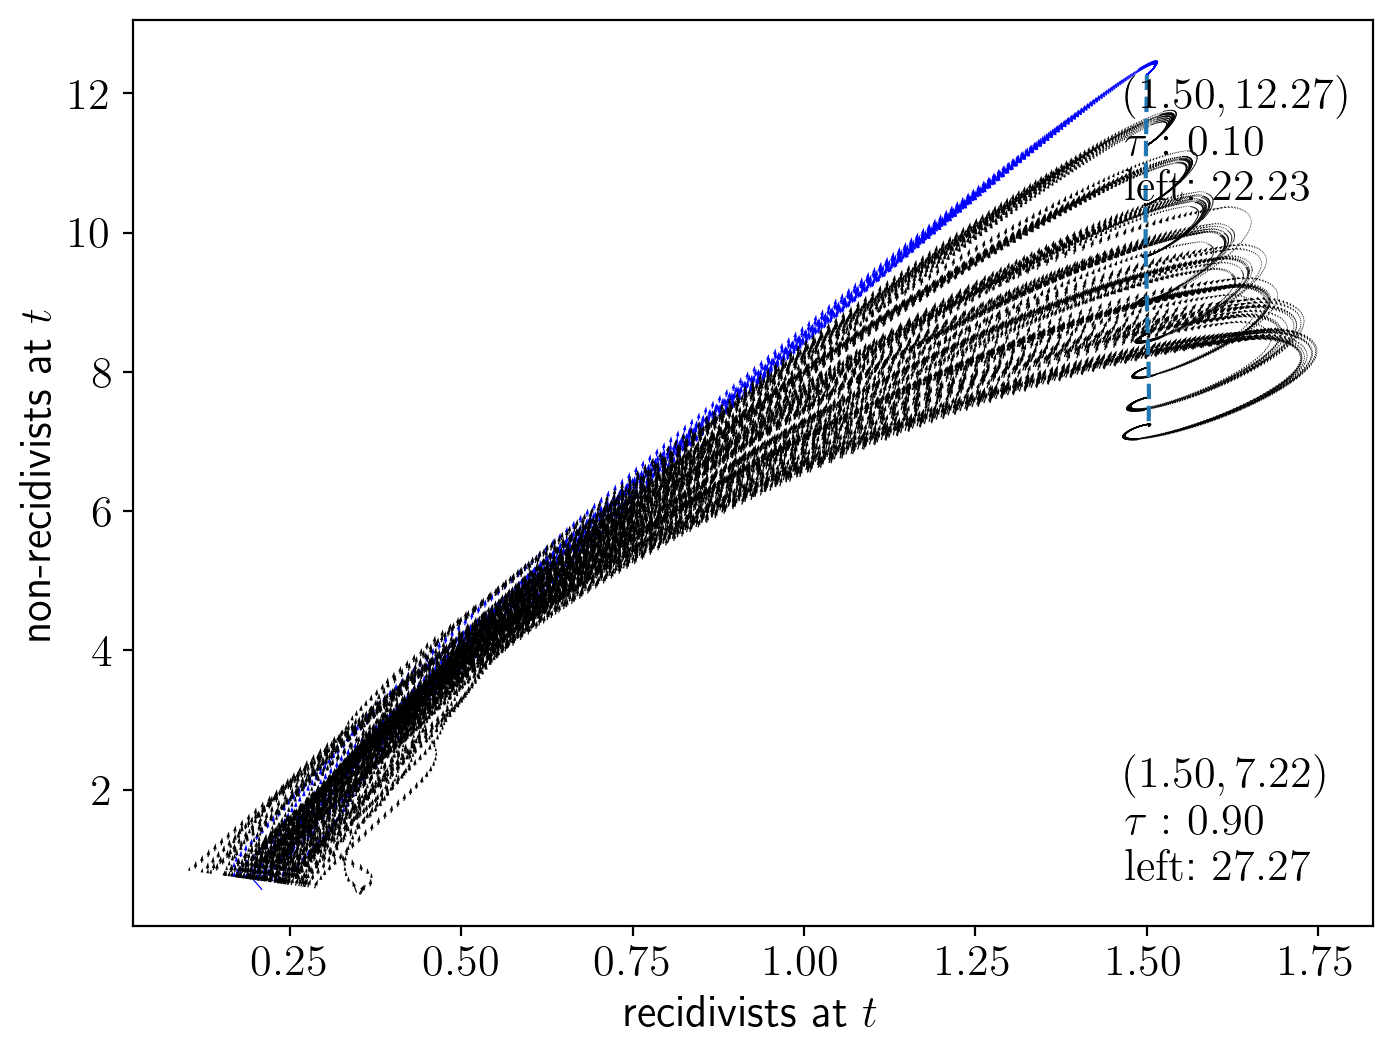

In [30]:
plot_equilibrium('positive', mixincost['ones'])